# Graph-level Classification

In SARS-CoV-2 studies, the spike protein, particularly the receptor-binding domain (RBD), is commonly mutated to map epitopes. In this project, we wish to predict the class of antibody epitopes for which an antibody sequence is likely to bind to. This will make us able to create epitope specific MSAs when feeding the classifier with multiple sequences. The MSA can enhance the performance when predicting antigen-antibody complexes using AlphaFold3 or similar tools.

The aim of this notebook is to classify the antibodies when representing the proteins as graphs. These representations are constructed from ESM-2 embeddings and contact scores. A Graph Neural Network (GNN) is trained for graph level predictions.

In [450]:
seperate = False
model_size = "3B"

### Preparation

We install PyTorch Geometric (PyG) used for to write and train GNNs. The required libraries are loaded.

In [451]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn.conv import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch.utils.data import random_split, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

### Data Import

We will import the data including information about the data partioning into train, validation and test. This insures a fair comparison of the performance across different classifiers.

In [452]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, '../data')
data = pd.read_csv(os.path.join(data_dir, 'raw/dataset_w_partition.csv'))
display(data)

,Unnamed: 0,Antibody Name,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,...,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,clus_vh,clus_vl,connected,partition
0,0,BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,...,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,1442,682,0,Validation
1,1,BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,...,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,1443,508,1,Train
2,2,BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,...,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,595,591,1,Test
3,3,BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,...,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,1444,683,2,Validation
4,4,BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,...,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1450,684,3,Validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,3046,BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,2157,913,807,Validation
3047,3047,BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,...,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,2158,456,1,Train
3048,3048,BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,2159,456,1,Train
3049,3049,BD55-6729,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,...,IGHV1-18,IGHJ6,IGLV3-25,IGLJ2,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...,2160,914,808,Validation


We will be interested in the epitope group and both the heavy and light chain in the data above. Let us look at the distribution of the lengths of the heavy and light chain.

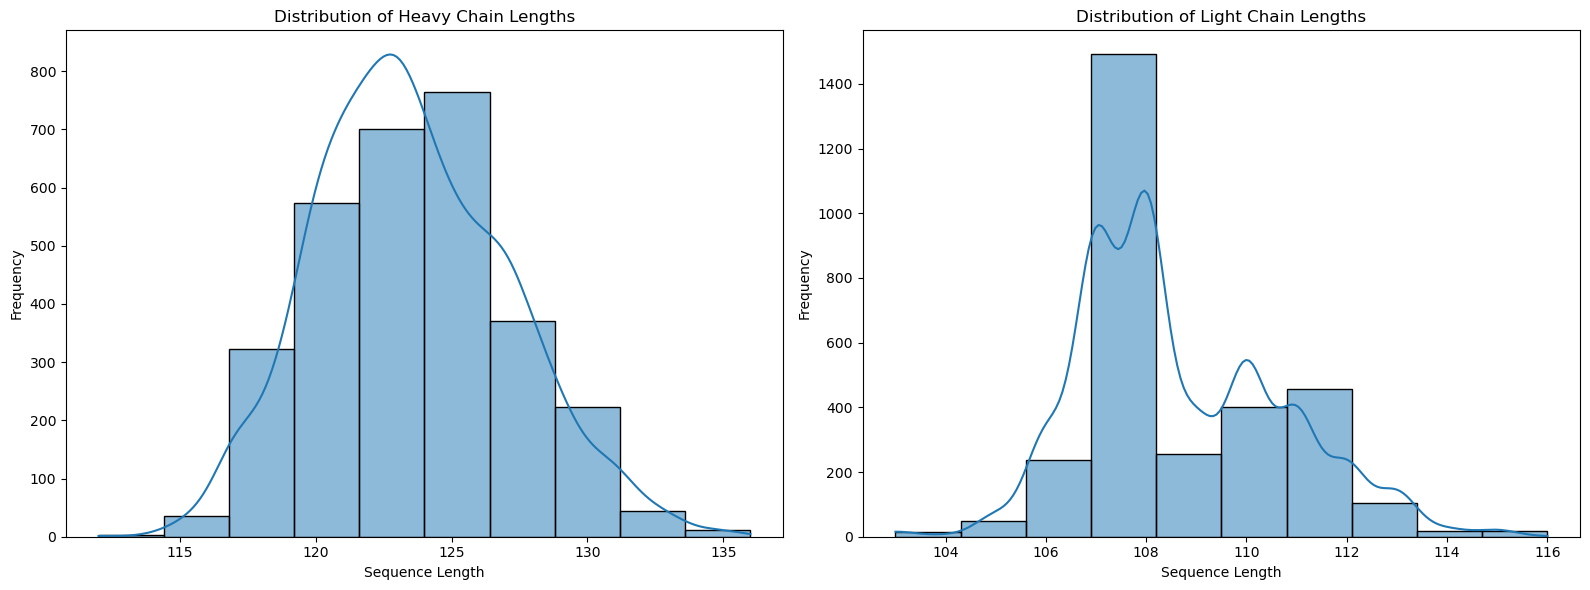

In [453]:
# Extract the sequencces
heavy_sequences = list(data['Heavy chain AA'])
light_sequences = list(data['Light chain AA'])

# Calculate lengths
heavy_sequence_lengths = [len(seq) for seq in heavy_sequences]
light_sequence_lengths = [len(seq) for seq in light_sequences]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  

# Heavy chain plot
sns.histplot(heavy_sequence_lengths, kde=True, bins=10, ax=axs[0])
axs[0].set_title('Distribution of Heavy Chain Lengths')
axs[0].set_xlabel('Sequence Length')
axs[0].set_ylabel('Frequency')

# Light chain plot
sns.histplot(light_sequence_lengths, kde=True, bins=10, ax=axs[1])
axs[1].set_title('Distribution of Light Chain Lengths')
axs[1].set_xlabel('Sequence Length')
axs[1].set_ylabel('Frequency')

# Adjust layout and show
plt.tight_layout()
plt.show()

The class label (Epitope Group) is a character. We convert this into a integer. The new column is named "Epitope Class". This will be our target for the classification model. 

In [454]:
# Generate mapping dictionary.
epitope_mapping = {group: code for code, group in enumerate(pd.Categorical(data['Epitope Group']).categories)}

# Map the Epitope Group column using the dictionary
data['Epitope Class'] = data['Epitope Group'].map(epitope_mapping)

display(data[['Epitope Group', 'Epitope Class', 'Heavy chain AA', 'Light chain AA']])

,Epitope Group,Epitope Class,Heavy chain AA,Light chain AA
0,C,2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...
1,A,0,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
2,A,0,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...
3,C,2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...
4,B,1,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...
...,...,...,...,...
3046,E2.2,7,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...
3047,F2,10,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...
3048,F1,9,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...
3049,F1,9,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...


The relation between epitope group and their class label is seen here:

In [455]:
print("Epitope to Group Mapping:", epitope_mapping)

Epitope to Group Mapping: {'A': 0, 'B': 1, 'C': 2, 'D1': 3, 'D2': 4, 'E1': 5, 'E2.1': 6, 'E2.2': 7, 'E3': 8, 'F1': 9, 'F2': 10, 'F3': 11}


### ESM-2 Representation

Results from feeding the ESM-2 model with the heavy and light chain sequences have already been generated. We will load these results in the format of a pickle file which retain the dict data format after running ESM-2.

In [456]:
if seperate:
    model_name = 'embed_EMS_' + model_size + '_seperate'
    path = '../../../s184243/AI4ProtEng_AIntibody/data/interim/' +  model_name
    with open(path, 'rb') as f:
        data_esm2 = pickle.load(f)

else:
    model_name = 'embed_EMS_' + model_size + '_together'
    path = '../../../s184243/AI4ProtEng_AIntibody/data/interim/' +  model_name
    with open(path, 'rb') as f:
        data_esm2 = pickle.load(f)

The ESM-2 model will output the representations as well as contact scores, which describes the likelihood that two specific residues in the protein are in close physical proximity when the protein folds into its three-dimensional structure.

In [457]:
data_esm2.keys()

dict_keys(['contacts', 'representations'])

We need to modify ESM-2 data a bit to combine the information from both chains. Thus, we must concatenate the representations, such that we get one representation vector per amino acid. However, all sequence representations will be of the same length, as the ESM-2 model apply padding as well as include a start and stop token, and we need to adjust for that as the first step. The contact matrices has only padding. The contact matrices will also be combined such that the contact map between the heavy and light chains will be filled with zero matrices. 

In [458]:
# Get number of proteins in the data
protein_num = int(data.shape[0])

# Extract representations
last_layer = list(data_esm2['representations'].keys())[0]
representations = data_esm2['representations'][last_layer]
contacts = data_esm2['contacts']

# Define empty lists
representations_list = []
contacts_list = []

if seperate:

    # Define heavy and light chain representations
    representations_heavy = representations[:protein_num, :, :]
    representations_light = representations[protein_num:, :, :]
    contacts_heavy = contacts[:protein_num, :, :]
    contacts_light = contacts[protein_num:, :, :]   
        
    for index in range(protein_num):
        
        # Remove the zero padding 
        # For representations, we also remove start and stop tokens
        representation_heavy = representations_heavy[index, 1:heavy_sequence_lengths[index]+1, :]
        representation_light = representations_light[index, 1:light_sequence_lengths[index]+1, :]
    
        # Concatenate the representations for both chains
        representations_list.append(torch.cat((representation_heavy, representation_light), dim=0))

        # Remove the zero padding. 
        contact_heavy = contacts_heavy[index, :heavy_sequence_lengths[index], :heavy_sequence_lengths[index]]
        contact_light = contacts_light[index, :light_sequence_lengths[index], :light_sequence_lengths[index]]
        
        # Make a combined contact matrix
        zero_padding_1 = torch.zeros(heavy_sequence_lengths[index], light_sequence_lengths[index])
        zero_padding_2 = torch.zeros(light_sequence_lengths[index], heavy_sequence_lengths[index])
        contact_full = torch.cat([torch.cat([contact_heavy, zero_padding_1], dim=1), torch.cat([zero_padding_2, contact_light], dim=1)], dim=0)
        
        # Save the contacts
        contacts_list.append(contact_full)
    
else:

    for index in range(protein_num):
        
        # Remove the zero padding, start, stop tokens, connecting token for the representations
        representation = representations[index, 1:heavy_sequence_lengths[index]+light_sequence_lengths[index]+2]
        representation = torch.cat((representation[:heavy_sequence_lengths[index]], representation[heavy_sequence_lengths[index]+1:]))
        representations_list.append(representation)
        
        # Remove start, stop tokens and connecting token for the representations
        contact = contacts[index, :heavy_sequence_lengths[index]+light_sequence_lengths[index]+1, :heavy_sequence_lengths[index]+light_sequence_lengths[index]+1]
        contact = np.delete(contact, heavy_sequence_lengths[index], axis=0)
        contact = np.delete(contact, heavy_sequence_lengths[index], axis=1)
        contacts_list.append(contact)

### Create Graphs

We now have the representation for each amino acids, which we will use as nodes. Amino acids with contacts above a certain threshold will be considered as neighbors. We will look at the distribution of contact scores to get an idea about what would be a reasonable threshold. 

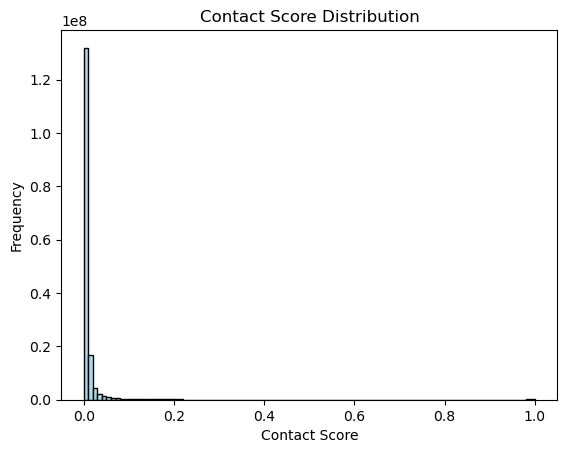

In [459]:
pooled_scores = np.concatenate([matrix.flatten() for matrix in contacts_list])

plt.hist(pooled_scores, bins=100, color='lightblue', alpha=1, edgecolor='black')
plt.title('Contact Score Distribution')
plt.xlabel('Contact Score')
plt.ylabel('Frequency')
plt.show()

Let's look at the percentiles. The large amount of zero values are highly influences by our zero padding, so we will look at the distribution of non-zero scores.

In [460]:
percentiles = np.percentile(pooled_scores[pooled_scores != 0], [25, 50, 75, 95, 99])

print("25th percentile:", percentiles[0])
print("50th percentile (Median):", percentiles[1])
print("75th percentile:", percentiles[2])
print("95th percentile:", percentiles[3])
print("99th percentile:", percentiles[4])

25th percentile: 0.003676906693726778
50th percentile (Median): 0.004802958108484745
75th percentile: 0.00831719022244215
95th percentile: 0.04457351006567478
99th percentile: 0.5671337097883171


We look at the contact map for the first sequence. 

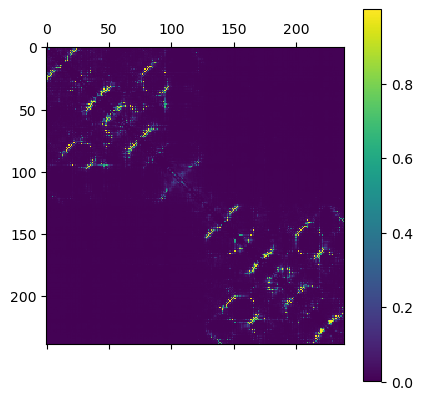

In [461]:
plt.matshow(contacts_list[0])
plt.colorbar()
plt.show()

We want to avoid to large graphs, which consider less important interactions. On the other hand, we want to capture the structure from the contact map. We decide to consider contacts above 0.2 as interacting amino acids. We create the graphs using PyG. Each protein graph will be generated by providing the folowing features:

- x: Node feature matrix with shape [num_nodes, num_node_features]. This will be sequence length (heavy + light chain) X representation dimension.

- edge_index: Graph connectivity with shape [2, num_edges]. This will be neighboring amino acids within the protein.

- edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]. This will be the score betweeen amino acids from the contact map. We will save this information, but in this project, we use a network, which does not take this into account. 

- data.y: This will be the target. In our case, we wish to predict the epitope class.

In [462]:
data2 = data
pygraphs = []
threshold = percentiles[3]
epitope_classes = torch.tensor(data['Epitope Class'].values, dtype=torch.long)
epitope_classes = epitope_classes.unsqueeze(0)

for index in range(protein_num):

  contacts = contacts_list[index]

  num_nodes = representations_list[index].shape[0]
  edge_indices_adj = torch.cat([torch.stack([torch.arange(num_nodes-1), torch.arange(1, num_nodes)], dim=0),
                               torch.stack([torch.arange(1, num_nodes), torch.arange(num_nodes-1)], dim=0)], dim = 1)

  edge_indices_contact = (contacts > threshold).nonzero(as_tuple=False).T

  # Combine both edge sets
  edge_indices_combined = torch.cat([edge_indices_adj, edge_indices_contact], dim=1)

  # Get the edge scores
  edge_scores = contacts[edge_indices_combined[0], edge_indices_combined[1]]

  # Create Data object
  graph = Data(x = representations_list[index],
               edge_index = edge_indices_combined,
               #edge_attr = edge_scores.unsqueeze(1), # As the network does not take the edge attribute into account, we exclude it here.
               y = epitope_classes[:, index])

  pygraphs.append(graph)

We can take a look at the first 10 observations to get an idea about the data object. 

In [463]:
pygraphs[:10]

[Data(x=[239, 2560], edge_index=[2, 3309], y=[1]),
 Data(x=[227, 2560], edge_index=[2, 3088], y=[1]),
 Data(x=[224, 2560], edge_index=[2, 3038], y=[1]),
 Data(x=[232, 2560], edge_index=[2, 3058], y=[1]),
 Data(x=[230, 2560], edge_index=[2, 3103], y=[1]),
 Data(x=[233, 2560], edge_index=[2, 3180], y=[1]),
 Data(x=[228, 2560], edge_index=[2, 3056], y=[1]),
 Data(x=[228, 2560], edge_index=[2, 3114], y=[1]),
 Data(x=[237, 2560], edge_index=[2, 3317], y=[1]),
 Data(x=[223, 2560], edge_index=[2, 3085], y=[1])]

### Define GNN for Classification

We are now ready to build and train a Graph Neural Network (GNN). Let's first sort the graph into training, validation and test sets. There is a lot of unbalance in the data. To force the model to also learn from the underrepresented classes, we will over-sample from the minority within the training data. 

In [464]:
# Get the indices for each partition
train_indices = np.where(data['partition'] == 'Train')[0]
val_indices   = np.where(data['partition'] == 'Validation')[0]
test_indices  = np.where(data['partition'] == 'Test')[0]

# Create sampler to represent the classes equally within the batches
y = np.array(data['Epitope Class'][train_indices])
class_counts = np.bincount(y)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Split dataset into training and test sets
train_graphs = [pygraphs[i] for i in train_indices]
val_graphs   = [pygraphs[i] for i in val_indices]
test_graphs  = [pygraphs[i] for i in test_indices]

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_graphs, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# Print the indices
print(f"Train proteins: {len(train_graphs)}")
print(f"Validation proteins: {len(val_graphs)}")
print(f"Test proteins: {len(test_graphs)}")

Train proteins: 2090
Validation proteins: 682
Test proteins: 279


/anaconda/envs/project27666/lib/python3.13/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


We define the architechture for the model. We will have 3 graph convolutional layers followed by two fully connected linear layers with the rectified linear unit function (ReLU) used as activation function. A log softmax is used after the final linear layer to output the log probability of a protein belonging to each of the 12 epitope classes. 

In [465]:
class GNN(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim_Conv1, hidden_dim_Conv2, hidden_dim_Conv3, hidden_dim_Linear, output_dim, dropout_rate = 0.25):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim_Conv1)
        self.conv2 = GCNConv(hidden_dim_Conv1, hidden_dim_Conv2)
        self.conv3 = GCNConv(hidden_dim_Conv2, hidden_dim_Conv3)
        
        self.fc1 = torch.nn.Linear(hidden_dim_Conv3, hidden_dim_Linear)
        self.fc2 = torch.nn.Linear(hidden_dim_Linear, output_dim)
        
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch) 
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

We will use Early Stopping to end the training process when no improvement is seen for the validation set to avoid overfitting.

In [466]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        Patience: How many epochs to wait after the last improvement.
        min_delta: Minimum change considered as improvement.
        """
        
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stopped_epoch = 0
        self.early_stop = False

    def __call__(self, val_loss, epoch):
        """
        Checks whether early stopping criteria are met.
        val_loss: Current validation loss.
        epoch: Current epoch.
        """
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch

### Train GNN

We will set the training details.

In [467]:
num_class = torch.max(epitope_classes).item() + 1
num_features = representations_list[0].size()[1]
dim_Conv1=int(num_features/2)
dim_Linear = int(num_features/8)

model = GNN(input_dim=num_features, hidden_dim_Conv1=dim_Conv1, hidden_dim_Conv2=dim_Conv1, hidden_dim_Conv3=dim_Conv1, hidden_dim_Linear=dim_Linear, output_dim = num_class)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay = 0.1)
scheduler = ReduceLROnPlateau(optimizer = optimizer, mode = 'min', patience=3, factor = 0.1)
early_stopping = EarlyStopping(patience=5, min_delta=0)
num_epoch = 500

In [468]:
print(dim_Conv1)
print(dim_Linear1)
print(dim_Linear2)

1280
80
40


Let's train!

In [469]:
# Save train results
loss_train = [] 
predictions_train = []
true_labels_train = []
acc_train = []
f1_train = []

# Save evaluation results
loss_eval  = []
predictions_eval = []
true_labels_eval = []
acc_eval = []
f1_eval = []

for epoch in range(num_epoch):

    loss_train_epoch = 0
    loss_eval_epoch = 0
    
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        loss_train_epoch += loss.item()

        # Save predictions and true labels
        pred = out.argmax(dim=1)
        predictions_train.extend(pred.squeeze(0).tolist())
        true_labels_train.extend(data.y.squeeze(0).tolist())
    
    loss_train_epoch /= len(train_indices)
    loss_train.append(loss_train_epoch)

    acc = accuracy_score(true_labels_train, predictions_train)
    acc_train.append(acc)
    
    f1 = f1_score(true_labels_train, predictions_train, average='weighted')
    f1_train.append(f1)
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss_eval_epoch += loss.item()

            # Save predictions and true labels
            pred = out.argmax(dim=1)
            predictions_eval.extend(pred.squeeze(0).tolist())
            true_labels_eval.extend(data.y.squeeze(0).tolist())

    loss_eval_epoch /= len(val_indices)
    loss_eval.append(loss_eval_epoch)

    acc = accuracy_score(true_labels_eval, predictions_eval)
    acc_eval.append(acc)

    f1 = f1_score(true_labels_eval, predictions_eval, average='micro')
    f1_eval.append(f1)
    
    scheduler.step(loss_eval_epoch)
    
    lr = scheduler.get_last_lr()[0]
    
    print(f"Epoch {epoch+1}, Train Loss: {loss_train_epoch:.4f}, Validation Loss: {loss_eval_epoch:.4f}, Learning rate {lr}")
    
    early_stopping(loss_eval_epoch, epoch)
    
    if early_stopping.early_stop:
        break

print("Training ended.")

Epoch 1, Train Loss: 0.1534, Validation Loss: 0.1619, Learning rate 0.001
Epoch 2, Train Loss: 0.1385, Validation Loss: 0.1472, Learning rate 0.001
Epoch 3, Train Loss: 0.1296, Validation Loss: 0.1419, Learning rate 0.001
Epoch 4, Train Loss: 0.1233, Validation Loss: 0.1455, Learning rate 0.001
Epoch 5, Train Loss: 0.1188, Validation Loss: 0.1464, Learning rate 0.001
Epoch 6, Train Loss: 0.1135, Validation Loss: 0.1394, Learning rate 0.001
Epoch 7, Train Loss: 0.1072, Validation Loss: 0.1366, Learning rate 0.001
Epoch 8, Train Loss: 0.1034, Validation Loss: 0.1554, Learning rate 0.001
Epoch 9, Train Loss: 0.1000, Validation Loss: 0.1344, Learning rate 0.001
Epoch 10, Train Loss: 0.0965, Validation Loss: 0.1316, Learning rate 0.001
Epoch 11, Train Loss: 0.0944, Validation Loss: 0.1327, Learning rate 0.001
Epoch 12, Train Loss: 0.0911, Validation Loss: 0.1355, Learning rate 0.001
Epoch 13, Train Loss: 0.0907, Validation Loss: 0.1350, Learning rate 0.001
Epoch 14, Train Loss: 0.0842, Vali

We take a look at the training process.

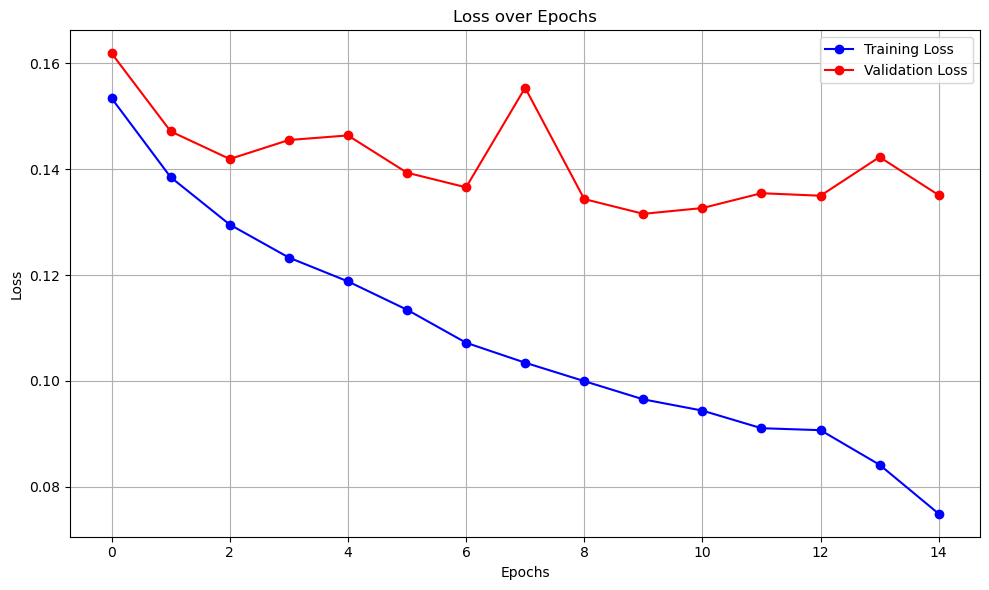

In [470]:
plt.figure(figsize=(10, 6))
plt.plot(loss_train, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(loss_eval, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

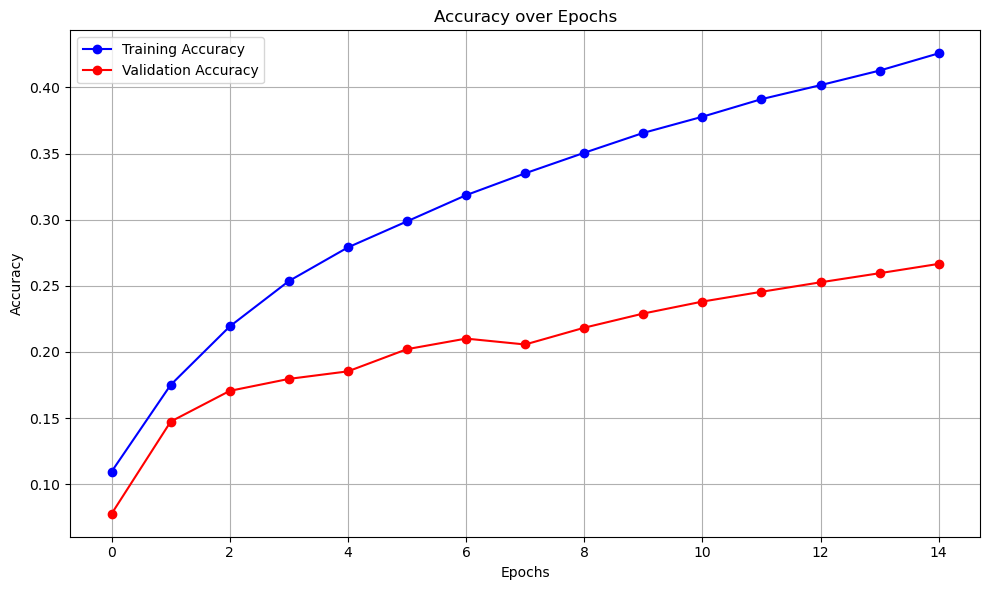

In [471]:
plt.figure(figsize=(10, 6))
plt.plot(acc_train, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(acc_eval, marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate GNN

We look at the performance when using the trained model on the evaluation and test set.

Validation Accuracy: 0.37


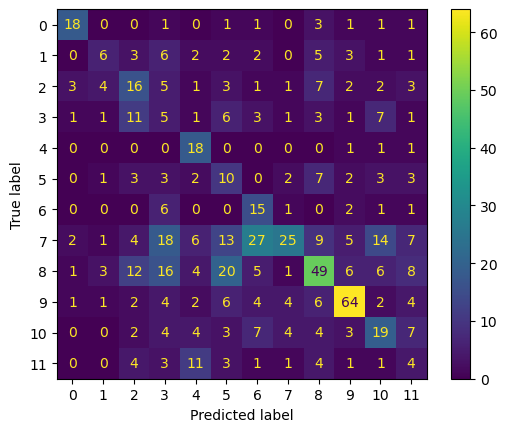

In [472]:
predictions = []
true_labels = []
correct = 0
figure_path = '../reports/figures/' + model_name + '_val' + '.png'

model.eval()
for data in val_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += (pred == data.y).sum().item()

    predictions.extend(pred.squeeze(0).tolist())
    true_labels.extend(data.y.squeeze(0).tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='micro')
recall = recall_score(true_labels, predictions, average='micro')

res = {'Validation': [accuracy, precision, recall]}
df = pd.DataFrame(res)

print(f"Validation Accuracy: {accuracy:.2f}")

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(cm).plot()
plt.savefig(figure_path)
plt.show()

Test Accuracy: 0.41


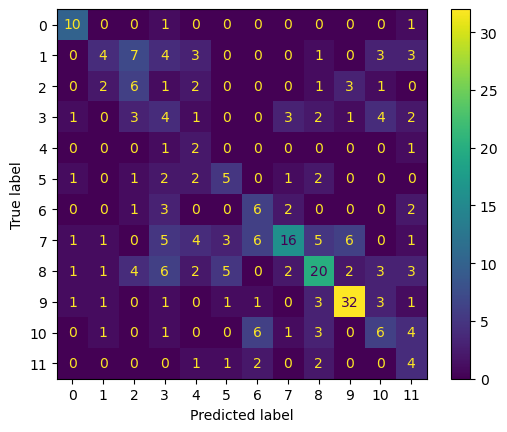

In [473]:
predictions = []
true_labels = []
correct = 0
figure_path = '../reports/figures/' + model_name + '_test' + '.png'

model.eval()
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += (pred == data.y).sum().item()

    predictions.extend(pred.squeeze(0).tolist())
    true_labels.extend(data.y.squeeze(0).tolist())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='micro')
recall = recall_score(true_labels, predictions, average='micro')

df['Test'] = [accuracy, precision, recall]
file_name = '../reports/result_files/' + model_name + '.xlsx'
df.to_excel(file_name, index=False, engine='openpyxl')

print(f"Test Accuracy: {accuracy:.2f}")

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(cm).plot()
plt.savefig(figure_path)
plt.show()